# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

# Connect to database

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [4]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 12
"""

In [5]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_101208\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38036 entries, 0 to 38035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38036 non-null  datetime64[ns]
 1   net_load  38036 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.4 KB


In [7]:
df

,ts,net_load
0,2019-03-01 15:15:00,1011.03
1,2019-03-01 15:30:00,797.85
2,2019-03-01 15:45:00,512.28
3,2019-03-01 16:00:00,241.41
4,2019-03-01 16:15:00,137.48
...,...,...
38031,2020-03-31 22:45:00,8.49
38032,2020-03-31 23:00:00,8.70
38033,2020-03-31 23:15:00,8.67
38034,2020-03-31 23:30:00,8.52


In [8]:
# Convert 'ts' to datetime and set as index
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df

,net_load
ts,
2019-03-01 15:15:00,1011.03
2019-03-01 15:30:00,797.85
2019-03-01 15:45:00,512.28
2019-03-01 16:00:00,241.41
2019-03-01 16:15:00,137.48
...,...
2020-03-31 22:45:00,8.49
2020-03-31 23:00:00,8.70
2020-03-31 23:15:00,8.67


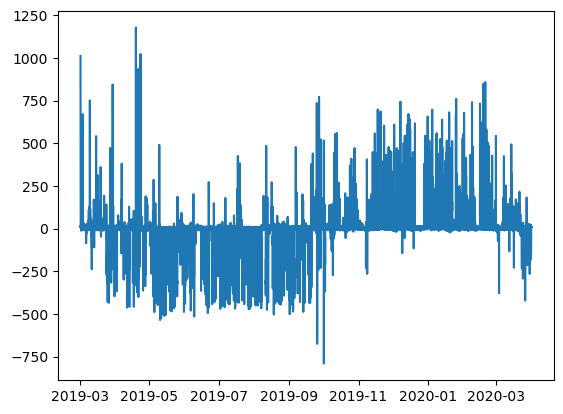

In [9]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (as seen in literature)

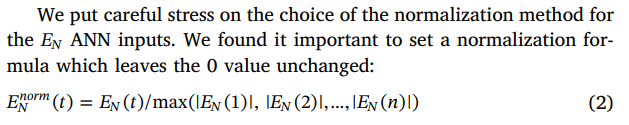



In [11]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

df

,net_load,net_load_norm
ts,,
2019-03-01 15:15:00,1011.03,0.858325
2019-03-01 15:30:00,797.85,0.677344
2019-03-01 15:45:00,512.28,0.434906
2019-03-01 16:00:00,241.41,0.204948
2019-03-01 16:15:00,137.48,0.116715
...,...,...
2020-03-31 22:45:00,8.49,0.007208
2020-03-31 23:00:00,8.70,0.007386
2020-03-31 23:15:00,8.67,0.007360


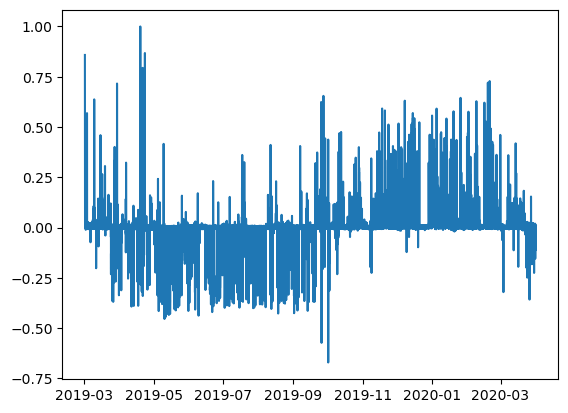

In [12]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Get time series data into a matrix that can be input into the LSTM model

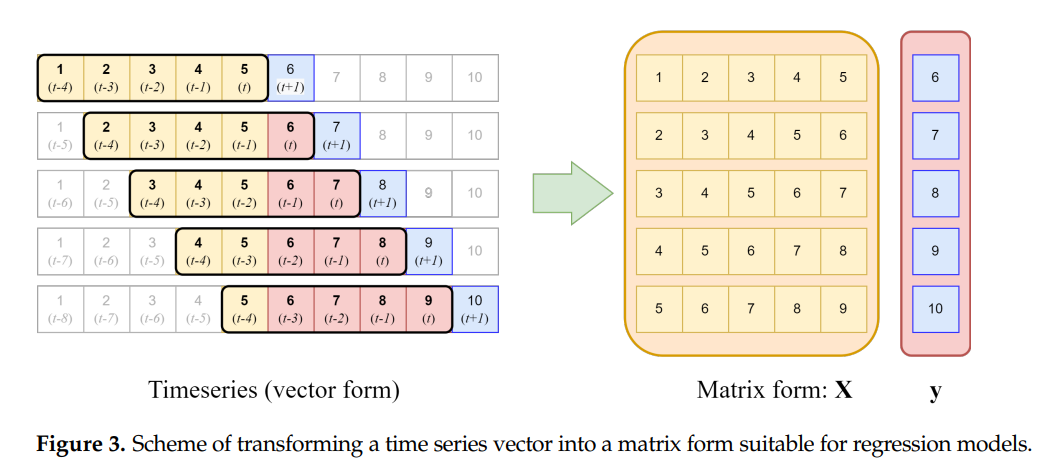

In [14]:
# Example
# Based on the first 5 hours, let's predict the 6th hour
# Based on the next 5 hours, let's predict the 7th hour
# etc. etc.

# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

# window_size is the number of previous time stamps that should be considered for the prediction

def df_to_X_y_with_ts(df, window_size):
    df_as_np = df.to_numpy()
    X = np.lib.stride_tricks.sliding_window_view(df_as_np, window_shape=window_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = df_as_np[window_size:]
    
    ts = df.index[window_size:]   # For y, we start from window_size to the end
    
    return X, y, ts

# 4 * hours * days
window_size = 4*24*7  # 1 week window size for hourly data

X, y, ts = df_to_X_y_with_ts(df['net_load_norm'], window_size)

print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y value: \n {y[0]}\n')
print(f'First timestamp: {ts[0]}')


Given the array X: 
 [ 8.58325339e-01  6.77343770e-01  4.34905893e-01  2.04947746e-01
  1.16715199e-01  6.41984532e-02  1.22250427e-02  1.20807192e-02
  1.04931616e-02  6.64736695e-03  1.51115111e-02  8.73581173e-03
  6.66434617e-03  6.46059546e-03  7.25861908e-03  7.18221256e-03
  6.46908507e-03  7.41143211e-03  1.30994728e-02  1.55444813e-02
  5.32298733e-03  3.95615964e-03  6.84262804e-03  6.09554210e-03
  1.64443803e-02  1.35409327e-02  8.24341418e-03  9.04992741e-03
  1.00856602e-02  9.99227445e-03  7.39445289e-03  1.01196186e-02
  1.00347225e-02  9.90737832e-03  6.19741746e-03  1.01281083e-02
  9.83946142e-03  8.63393638e-03  7.89534005e-03  1.00262329e-02
  9.73758606e-03  8.99050012e-03  7.71705818e-03  9.97529523e-03
  1.09176423e-02  1.03743070e-02  6.68981501e-03  9.89888871e-03
  1.03912863e-02  1.12062891e-02  6.91903456e-03  9.91586794e-03
  9.72060684e-03  9.85644064e-03  7.07184759e-03  9.27914696e-03
  1.00686810e-02  9.72060684e-03  7.08033721e-03  8.33679993e-03
  1.

# Split into train, test, val (train = 40 weeks, test = 1 day, val = 1 day)

In [16]:
def split_time_series(X, y, train_size, test_size, val_size, interval, ts):

    train_end = train_size * interval
    test_end = train_end + test_size * interval

    X_train, y_train, ts_train = X[:train_end], y[:train_end], ts[:train_end]
    X_test, y_test, ts_test = X[train_end:test_end], y[train_end:test_end], ts[train_end:test_end]
    X_val, y_val, ts_val = X[test_end:test_end+val_size*interval], y[test_end:test_end+val_size*interval], ts[test_end:test_end+val_size*interval]

    return X_train, y_train, ts_train,  X_test, y_test, ts_test, X_val, y_val, ts_val

interval = 96  # no. of 15-min increments in 1 day

# Use the function to split your dataset
X_train, y_train, ts_train, X_test, y_test, ts_test, X_val, y_val, ts_val = split_time_series(
    X, y,
    train_size=40*7,  # 40 weeks
    test_size=1,     # 1 day
    val_size=1,      # 1 day
    interval=interval,
    ts = ts
)

X_train.shape, y_train.shape, ts_train.shape, X_test.shape, y_test.shape, ts_test.shape, X_val.shape, y_val.shape, ts_val.shape

((26880, 672, 1),
 (26880,),
 (26880,),
 (96, 672, 1),
 (96,),
 (96,),
 (96, 672, 1),
 (96,),
 (96,))

# Build LSTM model

In [ ]:
model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

In [ ]:
cp1 = ModelCheckpoint('model3.keras', save_best_only=True)
model1.compile(loss='mae', optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

# Fit LSTM model

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

# Check training results

In [ ]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

train_results

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_results['Actuals'][0:700], label='Actual')
plt.plot(train_results['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_train, train_predictions)}")

# Check validation results

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(val_results['Actuals'], label='Actual')
plt.plot(val_results['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_val, val_predictions)}")

# Check test results

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Actuals'], label='Actual')
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_test, test_predictions)}")